In [1]:
# Import Library
# !pip install pandas numpy gensim tensorflow scikit-learn Sastrawi matplotlib

import pandas as pd
import numpy as np
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("berhasil mengimport library")

berhasil mengimport library


In [2]:
# Load dataset
data = pd.read_excel("2000_Kalimat_Kinerja_Pesantren_Unik.xlsx")
print("Contoh 5 data pertama:")
print(data.head())
print("\nDistribusi Sentimen:")
print(data["Sentimen"].value_counts())

Contoh 5 data pertama:
   No                                            Kalimat                Aspek  \
0   1  Pengajar memiliki kompetensi memberikan perhat...        Kualitas Guru   
1   2  Pengalaman guru masih perlu ditingkatkan. Meng...        Kualitas Guru   
2   3  Beberapa guru masih perlu ditingkatkan. Mengur...        Kualitas Guru   
3   4  Prestasi santri meraih prestasi akademik dan n...             Prestasi   
4   5  Proses belajar mengajar sangat efektif dan men...  Kualitas Pengajaran   

  Sentimen  
0  Positif  
1  Negatif  
2  Negatif  
3  Positif  
4  Positif  

Distribusi Sentimen:
Sentimen
Positif    108
Negatif    108
Netral     108
Name: count, dtype: int64


In [3]:
# text processing
# Fungsi cleaning teks
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)  # Hapus URL, mention, hashtag
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.lower()  # Case folding
    
    # Stopword removal
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(text)
    
    # Stemming
    stemmer = StemmerFactory().create_stemmer()
    text = stemmer.stem(text)
    return text

# Apply cleaning
data["Cleaned_Text"] = data["Kalimat"].apply(clean_text)
print("\nteks setelah cleaning:")
print(data[["Kalimat", "Cleaned_Text"]].head())


Contoh teks setelah cleaning:
                                             Kalimat  \
0  Pengajar memiliki kompetensi memberikan perhat...   
1  Pengalaman guru masih perlu ditingkatkan. Meng...   
2  Beberapa guru masih perlu ditingkatkan. Mengur...   
3  Prestasi santri meraih prestasi akademik dan n...   
4  Proses belajar mengajar sangat efektif dan men...   

                                        Cleaned_Text  
0  ajar milik kompetensi beri perhati penuh santr...  
1       alam guru perlu tingkat kurang kualitas ajar  
2   beberapa guru perlu tingkat kurang kualitas ajar  
3  prestasi santri raih prestasi akademik nonakad...  
4  proses ajar ajar sangat efektif tarik ajar lan...  


In [4]:
# pembagian train data dan testing data

# Encoding sentimen (Negatif:0, Netral:1, Positif:2)
sentimen_map = {"Negatif": 0, "Netral": 1, "Positif": 2}
data["Sentimen_Encoded"] = data["Sentimen"].map(sentimen_map)

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    data["Cleaned_Text"], 
    data["Sentimen_Encoded"], 
    test_size=0.2, 
    stratify=data["Sentimen_Encoded"],
    random_state=42
)
print("\nJumlah data training dan testing:")
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")
print("Distribusi label training:")
print(y_train.value_counts())


Jumlah data training dan testing:
Training: 259, Testing: 65
Distribusi label training:
Sentimen_Encoded
0    87
2    86
1    86
Name: count, dtype: int64


In [10]:
# oversampling pada vector
# Gabungkan X_train dan y_train
train_data = pd.DataFrame({"text": X_train, "label": y_train})
# Pisahkan per kelas
df_netral = train_data[train_data["label"] == 1]
df_positif = train_data[train_data["label"] == 2]
df_negatif = train_data[train_data["label"] == 0]

# Oversampling positif & negatif
df_positif_oversampled = resample(df_positif, replace=True, n_samples=len(df_netral), random_state=42)
df_negatif_oversampled = resample(df_negatif, replace=True, n_samples=len(df_netral), random_state=42)

# print(df_positif_oversampled)
# Gabungkan kembali
train_data_balanced = pd.concat([df_netral, df_positif_oversampled, df_negatif_oversampled])
print("\nDistribusi label setelah oversampling:")
print(train_data_balanced["label"].value_counts())


Distribusi label setelah oversampling:
label
1    86
2    86
0    86
Name: count, dtype: int64


In [11]:
# tokenizing dan pading
# Tokenisasi
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data_balanced["text"])

# Konversi teks ke sequence
X_train_seq = tokenizer.texts_to_sequences(train_data_balanced["text"])
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 100  # Panjang maksimal sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

print("\nContoh hasil padding:")
print(X_train_padded[0])


Contoh hasil padding:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  51   1  12  27  15   7  49 112]


In [12]:
# Hyperparameter optimal dari pengujian
embed_dim = 100
lstm_units = 198
dropout_rate = 0.2

# Model architecture
model = Sequential([
    Embedding(input_dim=5000, output_dim=embed_dim, input_length=max_len),
    SpatialDropout1D(dropout_rate),
    LSTM(lstm_units, dropout=dropout_rate),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nSummary model:")
model.summary()


Summary model:


c:\Users\AL-IKHLASH LAMPOKO\Documents\belajar\coba\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4851 - loss: 1.0877 - val_accuracy: 0.7538 - val_loss: 1.0363
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9188 - loss: 0.9928 - val_accuracy: 0.8615 - val_loss: 0.8699
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9569 - loss: 0.7374 - val_accuracy: 0.9385 - val_loss: 0.5548
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9521 - loss: 0.3822 - val_accuracy: 0.9231 - val_loss: 0.2787
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9753 - loss: 0.1402 - val_accuracy: 1.0000 - val_loss: 0.1097
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9939 - loss: 0.0378 - val_accuracy: 1.0000 - val_loss: 0.0591
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9687 - loss: 0.3592 - val_accuracy: 1.0000 - val_loss: 0.0594
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.0604


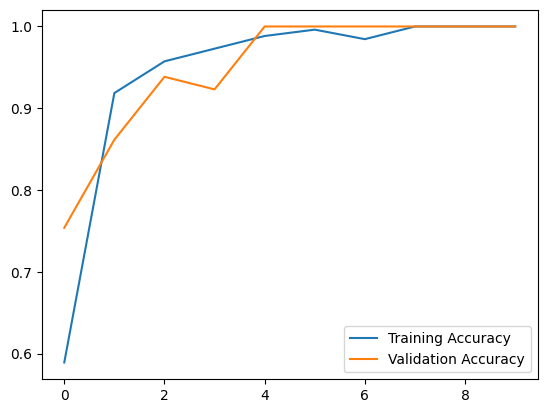

In [13]:
# Pelatihan Model   
# Callback untuk early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training
history = model.fit(
    X_train_padded, 
    train_data_balanced["label"],
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop]
)

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [29]:
# Evaluasi Model
# Prediksi
y_pred = np.argmax(model.predict(X_test_padded), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=sentimen_map.keys()))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Classification Report:
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00        21
      Netral       1.00      1.00      1.00        22
     Positif       1.00      1.00      1.00        22

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65


Confusion Matrix:
[[21  0  0]
 [ 0 22  0]
 [ 0  0 22]]


In [30]:
# simpan model
model.save("model_lstm_pesantren.h5")

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load model
model = load_model("model_lstm_pesantren.h5")
def predict_aspect(text):
    # Rule-based: Cek kata kunci untuk setiap aspek
    aspect_keywords = {
        "Kualitas Pengajaran": ["ajar", "ustadz", "kurikulum", "belajar"],
        "Fasilitas": ["asrama", "kamar", "fasilitas", "bersih", "kotor"],
        "Kualitas Guru": ["guru", "ustadz", "pengajar", "sabar"],
        "Prestasi": ["prestasi", "juara", "lomba", "menang"]
    }
    
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    
    # Cek kata yang cocok dengan aspek
    for aspect, keywords in aspect_keywords.items():
        if any(keyword in words for keyword in keywords):
            return aspect
    return "Umum"  # Default jika tidak ada aspek terdeteksi

def predict_text_with_aspect(text):
    sentiment = predict_sentiment(text)
    aspect = predict_aspect(text)
    return {
        "Text": text,
        "Sentimen": sentiment,
        "Aspek": aspect
    }

# Contoh penggunaan
new_texts = [
    "Fasilitas pesantren tidak nyaman dan bersih.",
    "Pengajaran ustadz kurang jelas.",
    "Prestasi santri di olimpiade membanggakan."
]

# Hasil prediksi
results = [predict_text_with_aspect(text) for text in new_texts]

# Konversi ke DataFrame untuk tampilan rapi
import pandas as pd
results_df = pd.DataFrame(results)
print("\nHasil Prediksi:")
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Hasil Prediksi:
                                           Text Sentimen                Aspek
0  Fasilitas pesantren tidak nyaman dan bersih.  Positif            Fasilitas
1               Pengajaran ustadz kurang jelas.  Negatif  Kualitas Pengajaran
2    Prestasi santri di olimpiade membanggakan.  Negatif             Prestasi
